# Load Python packages

In [1]:
# Load packages
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters, mobility #, sciensano, google
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import lockdown_func, mobility_update_func, policies_wave1_4prev

# Moving average for visualisation
from covid19model.visualization.utils import moving_avg
from covid19model.models.utils import read_pops, read_coordinates_nis, initial_state

# Download function for complete calibration
# covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'arr'

# Load model parameter values
The model is supported by many parameters, which must be loaded into the model later on

In [2]:
# Contact matrices
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial=agg)
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg)
start_date = pd.to_datetime('2020-03-18')

# Add the social effect of the first lockdown
params.update({'Nc_all' : Nc_all,
               'df_google' : df_google,
               'l': 13.25,
               'tau': .1,
               'prev_schools': 1, # hard-coded
               'prev_work': 0.16, # 0.5 # taken from Tijs's analysis
               'prev_rest': 0.28, # 0.5 # taken from Tijs's analysis
               'prev_home' : 0.7})# 0.5 # taken from Tijs's analysis

# Add parameters for the daily update of mobility
params.update({'agg' : agg,
               'default_mobility' : None}) # mobility defaults to average mobility

# Add clearly distinct infectivity parameters for demonstration
beta_R = 0.0431
beta_U = 0.0422
beta_M = 0.0399
params.update({'beta_R' : beta_R,
               'beta_U' : beta_U,
               'beta_M' : beta_M})

# random mobility
# p_without_gent = np.random.random(43)
# params.update({'p' : p_without_gent})

# Initialise model
The spatial model must have an initial condition

In [3]:
# Initial states
initE = initial_state(dist='bxl', agg=agg, age=40, number=1) # 1000 40-somethings dropped in Arlon
initial_states = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : policies_wave1_4prev, 'place' : mobility_update_func}, spatial=agg)


warmup=51
end_date = pd.to_datetime('2020-05-15')
start_date = pd.to_datetime('2020-03-05')
out = model_wave1.sim(end_date, start_date=start_date, warmup=warmup)

ValueError: The specified parameters don't exactly match the predefined parameters. Redundant parameters: {'K_inf', 'K_hosp'}. Missing parameters: {'e', 'v', 'N_vacc', 'leakiness', 'K'}

In [118]:
infected?

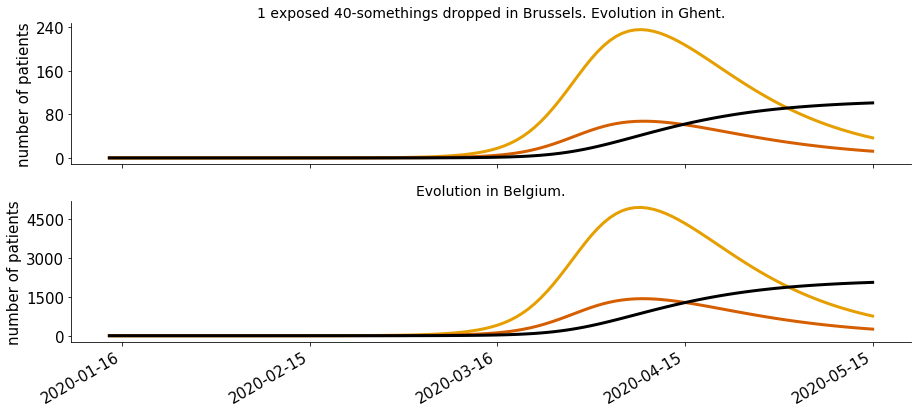

In [119]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(13,6))

infected(out.sel(place=44000), ax=ax1)
ax1.grid(False)
ax1.set_xlabel(None)
ax1.set_title("1 exposed 40-somethings dropped in Brussels. Evolution in Ghent.", fontsize=14)
ax1.get_legend().remove()

# infected(out.sel(place=21000), ax=ax2)
infected(out.sum(dim='place'), ax=ax2)
ax2.grid(False)
ax2.set_xlabel(None)
ax2.set_title("Evolution in Belgium.", fontsize=14)
ax2.get_legend().remove()

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
# plt.savefig("test", dpi=400, bb_boxes='tight')

In [79]:
show_map?

In [122]:
# Visualisation in geopandas
from covid19model.visualization.output import show_map
import geopandas as gp

shp_dir = "../../data/raw/GIS/shapefiles/BE/"
provinces = gp.read_file(shp_dir + "AD_4_Province.shp")
arrondissements = gp.read_file(shp_dir + "AD_3_District.shp")

start_simulation = start_date - datetime.timedelta(days=warmup)
for idx, day in enumerate(pd.date_range(start=start_simulation, end=end_date)):
    print(f'working on day {day.date()} ...', end='\r')
    fig = show_map(out, arrondissements, day=day, lin=False, rel=False, verbose=False, ts_graph=['E', 'H_in', 'D'])
    plt.savefig(f'delete_this_directory/first_calibration_fig{idx}.png', dpi=400)
    plt.close()

# Visualising different betas

In [102]:
from covid19model.models.utils import stratify_beta
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
arrondissements = gp.read_file("../../data/raw/geopandas/BE/AD_3_District.shp")

beta_classes_arr = stratify_beta('Rural', 'Urban', 'Metropolitan', 'arr')
NIS_codes = pd.read_csv('../../data/interim/demographic/area_arr.csv')['NIS'].values

beta_per_NIS = dict({})
for idx, NIS in enumerate(NIS_codes):
    beta_per_NIS[NIS] = beta_classes_arr[idx]

[]

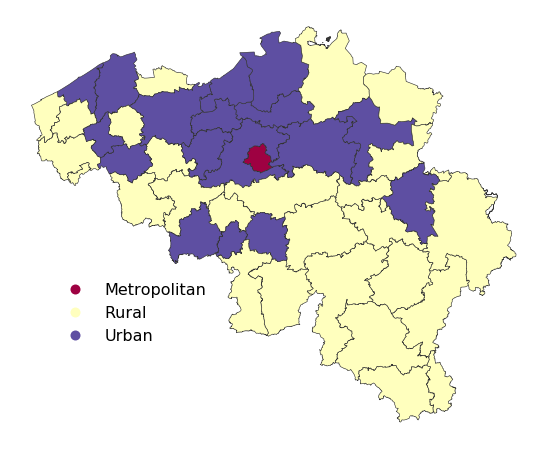

In [108]:
arrondissements['beta_class'] = None
for NIS in beta_per_NIS:
    arrondissements.loc[arrondissements['NISCode']==str(NIS),'beta_class']=beta_per_NIS[NIS]

    
fig, ax = plt.subplots(figsize=(14,8))
arrondissements.plot(ax=ax, column='beta_class', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.4, .4),'fontsize':16,'frameon':False})
ax.set_axis_off()

# plt.savefig("beta_classes", dpi=400, )

# Scratches